In [1]:
import os
import time
import uuid
import cv2
import imghdr
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
import cv2
import json
import numpy as np
import os
import shutil
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [ ]:
# IMAGES_PATH = os.path.join('data','images')
# image_exts = ['jpeg','jpg','bmp','png']

# for image in os.listdir(IMAGES_PATH):
#     image_path = os.path.join(IMAGES_PATH, image)
#     im = Image.open(image_path)
#     rgb_im = im.convert('RGB')
#     rgb_im.save(image_path)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
        
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))

In [ ]:
!labelme

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [ ]:
for file in os.listdir('data/labels'):
    filename = os.path.splitext(file)[0]
    for folder in ['train', 'test', 'val']:
        for ext in ['.jpg','.png','.jpeg','.bmp']:
            image_path = os.path.join('data', folder, 'images', filename + ext)
            if os.path.exists(image_path):
                label_path = os.path.join('data', folder, 'labels', filename + '.json')
                shutil.move(os.path.join('data', 'labels', file), label_path)
                break

In [3]:
augmentor = alb.Compose([
    # alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),
    alb.ToGray(p=0.2)  # Convert to grayscale with a probability of 0.2
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


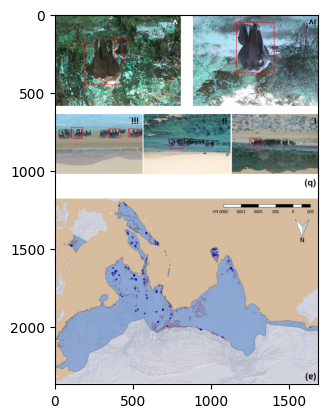

In [3]:
# img = cv2.imread(os.path.join('data', 'train', 'images', '41598_2023_30650_Fig1_HTML.png'))
# with open(os.path.join('data', 'train', 'labels', '41598_2023_30650_Fig1_HTML.json'), 'r') as f:
#     label = json.load(f)
# class_labels = [shape['label'] for shape in label['shapes']]
# bboxes = []
# for shape in label['shapes']:
#     coords = shape['points']
#     bbox = [
#         min(coords[0][0], coords[1][0]),
#         min(coords[0][1], coords[1][1]),
#         max(coords[0][0], coords[1][0]),
#         max(coords[0][1], coords[1][1])
#     ]
#     bboxes.append(bbox)

# x = img.shape[1]  # Width of the image
# y = img.shape[0]  # Height of the image

# # Normalize coordinates to range [0, 1]
# normalized_bboxes = [[bbox[0] / x, bbox[1] / y, bbox[2] / x, bbox[3] / y] for bbox in bboxes]

# # Apply augmentation
# augmented = augmentor(image=img, bboxes=normalized_bboxes, class_labels=class_labels)

# # Denormalize and draw the bounding boxes on the image
# for bbox in augmented['bboxes']:
#     denormalized_bbox = [coord * dim for coord, dim in zip(bbox, [x, y, x, y])]
#     cv2.rectangle(augmented['image'],
#                   (int(denormalized_bbox[0]), int(denormalized_bbox[1])),
#                   (int(denormalized_bbox[2]), int(denormalized_bbox[3])),
#                   (255, 0, 0),
#                   2)

# # Display the augmented image
# plt.imshow(augmented['image'])
# plt.show()

In [21]:
output_dir = 'aug_data'

# Remove files from the output directory
for root, dirs, files in os.walk(output_dir):
    for file in files:
        file_path = os.path.join(root, file)
        os.remove(file_path)

In [5]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    class_label = [label['class']]
    bboxes = label['bbox']

    # Determine the maximum number of boxes in the dataset
    max_length = max(len(bboxes) for bboxes in bboxes)

    # Pad the bboxes with zeros to ensure consistent shape
    bboxes_padded = [bbox + [0, 0] * (max_length - len(bbox)) for bbox in bboxes]

    return class_label, bboxes_padded

# Generate augmented images
for partition in ['train', 'test', 'val']:
    image_dir = os.path.join('data', partition, 'images')
    label_dir = os.path.join('data', partition, 'labels')
    output_image_dir = os.path.join('aug_data', partition, 'images')
    output_label_dir = os.path.join('aug_data', partition, 'labels')
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_path)
        x = img.shape[1]  # Width of the image
        y = img.shape[0]  # Height of the image

        label_file = os.path.join(label_dir, f'{os.path.splitext(image_file)[0]}.json')
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                label = json.load(f)
            class_labels = [shape['label'] for shape in label['shapes']]
            bboxes = []
            for shape in label['shapes']:
                coords = shape['points']
                bbox = [
                    min(coords[0][0], coords[1][0]),
                    min(coords[0][1], coords[1][1]),
                    max(coords[0][0], coords[1][0]),
                    max(coords[0][1], coords[1][1])
                ]
                bboxes.append(bbox)

            # Normalize coordinates to range [0, 1]
            normalized_bboxes = [[bbox[0] / x, bbox[1] / y, bbox[2] / x, bbox[3] / y] for bbox in bboxes]

            try:
                for i in range(10):  # Perform augmentation and save 5 augmented images
                    augmented = augmentor(image=img, bboxes=normalized_bboxes, class_labels=class_labels)

                    # Save augmented image
                    augmented_image_file = f'{os.path.splitext(image_file)[0]}.{i}.jpg'
                    augmented_image_path = os.path.join(output_image_dir, augmented_image_file)
                    cv2.imwrite(augmented_image_path, augmented['image'])

                    # Prepare annotation
                    annotation = {}
                    annotation['image'] = augmented_image_file

                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [[0, 0, 0, 0]]
                        annotation['class'] = [0]
                    else:
                        class_labels = augmented['class_labels']
                        label_mapping = {
                            'Asian Elephant': 0,
                            'Sumatran Tiger': 1,
                            'Pig Tailed Macaque': 2,
                            'Sun Bears': 3,
                            'Rhinoceros Hornbill': 4
                        }
                        annotation['bbox'] = augmented['bboxes']
                        annotation['class'] = [label_mapping[label] for label in class_labels]
                    # Save annotation
                    augmented_label_file = f'{os.path.splitext(image_file)[0]}.{i}.json'
                    augmented_label_path = os.path.join(output_label_dir, augmented_label_file)
                    with open(augmented_label_path, 'w') as f:
                        json.dump(annotation, f)
            except Exception as e:
                print(e)

In [8]:
# Load augmented dataset
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

train_images = tf.data.Dataset.list_files('aug_data/train/images/*', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)

test_images = tf.data.Dataset.list_files('aug_data/test/images/*', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x / 255)

val_images = tf.data.Dataset.list_files('aug_data/val/images/*', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x:     tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x / 255)

In [11]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    class_labels = label['class'][0]
    bboxes = label['bbox'][0]
    return str(class_labels),bboxes

In [12]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.string, tf.float32]))

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.string, tf.float32]))

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.string, tf.float32]))

train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

data_samples = train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


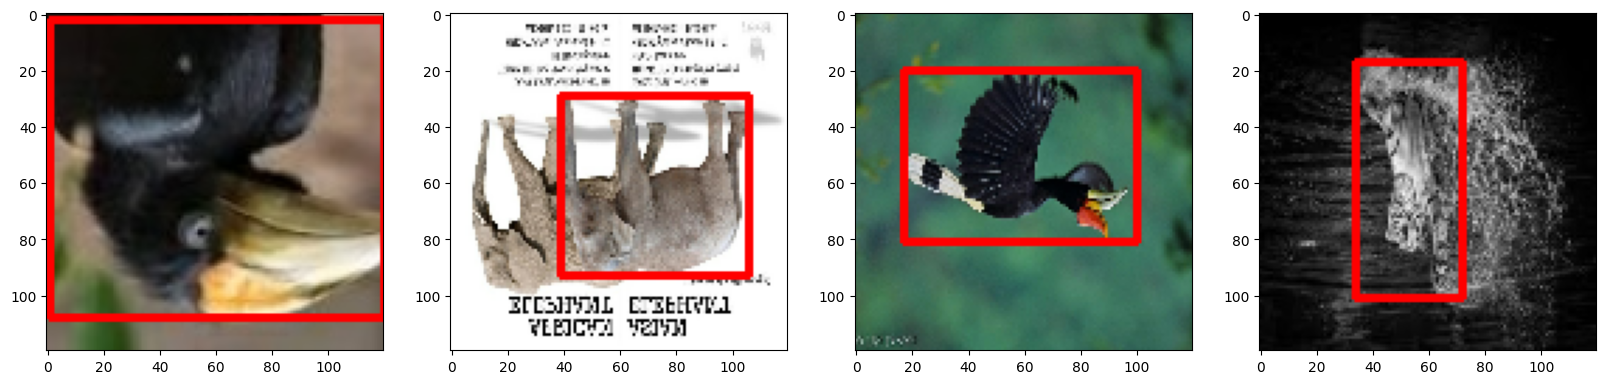

In [15]:
res = next(data_samples)

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    cv2.rectangle(sample_image,\
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),\
                 tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                 (255,0,0),2)
    ax[idx].imshow(sample_image)

plt.show()



In [16]:
vgg = VGG16(include_top=False)
## vgg16 is a classification model. so we are substituting the final layers as we require regression for bounding box
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)
    #CLassification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    #Regression Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    animaltracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return animaltracker
animaltracker = build_model()
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2]-yhat[:,:2]))
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    return delta_coord + delta_size
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [18]:
class AnimalTracker(Model):
    def __init__(self, animaltracker, **kwargs):
        super().__init__(**kwargs)
        self.model = animaltracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            # Convert class labels to numerical values
            class_labels = tf.strings.to_number(y[0], out_type=tf.float32)

            batch_classloss = self.closs(class_labels, classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}


    def test_step(self, batch, **kwargs):
        X,y = batch
        classes, coords =self.model(X, training=False)
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5*batch_classloss
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [19]:
model = AnimalTracker(animaltracker)
model.compile(opt, classloss, regressloss)
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])

  3/698 [..............................] - ETA: 43:47 - total_loss: 5.4221 - class_loss: 0.3202 - regress_loss: 5.2620  

KeyboardInterrupt: 

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,\
                     tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),\
                     tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),\
                     (255,0,0),2)
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('animaltracker.h5')